0


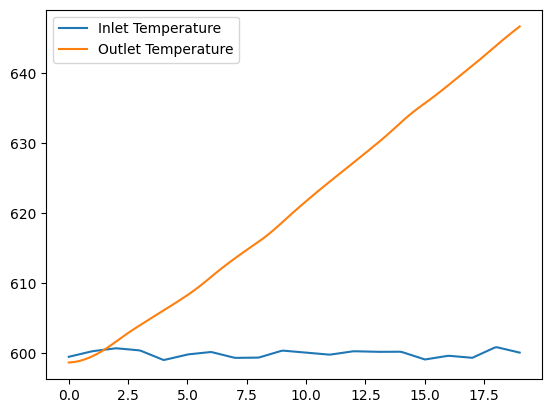

In [3]:
import pyomo.environ as pyo
from idaes.core import FlowsheetBlock
from idaes.models.unit_models import Heater
from idaes.models.properties.general_helmholtz import (
    HelmholtzParameterBlock,
    PhaseType,
    StateVars,
)
from idaes.core.util.model_statistics import degrees_of_freedom
from data import temperature, pressure, power, indexes
import math

m = pyo.ConcreteModel()
m.fs = FlowsheetBlock(dynamic=True,time_units=pyo.units.s,time_set=[0,19])
m.fs.properties = HelmholtzParameterBlock(
    pure_component="h2o",
    phase_presentation=PhaseType.MIX,
    state_vars=StateVars.TPX,
)
m.fs.heater = Heater(property_package=m.fs.properties,dynamic=True,has_holdup=True,)


# do a linear interpolation of temperature data

@m.fs.heater.Constraint(m.fs.time)
def heat_duty_eq(b, t):
    lower_index = math.floor(t)
    upper_index = math.ceil(t)
    time_diff = t - lower_index
    return (
        b.heat_duty[t] == (1 - time_diff) * power[indexes[lower_index]] + time_diff * power[indexes[upper_index]]
    )


pyo.TransformationFactory("dae.finite_difference").apply_to(
    m.fs, 
    nfe=200, # Number of finite elements to use for discretization 
    wrt=m.fs.time, 
    scheme="BACKWARD"
)



# If we're fixing all the variables, we have to do it after the transformation
for t in m.fs.time:
    # interpolate inlet temperature data
    lower_index = math.floor(t)
    upper_index = math.ceil(t)
    time_diff = t - lower_index
    m.fs.heater.inlet.temperature[t].fix((1 - time_diff) * temperature[indexes[lower_index]] + time_diff * temperature[indexes[upper_index]])
    m.fs.heater.inlet.flow_mol[t].fix(100)
    m.fs.heater.inlet.vapor_frac[t].fix(1)
    m.fs.heater.inlet.pressure[t].fix(101325)
    
m.fs.heater.control_volume.volume.fix(10)
# Fix the derivative variables to zero at time 0 (steady state assumption)
m.fs.fix_initial_conditions()
# or, specify holdup
#m.fs.heater.control_volume.material_holdup[0, 'Mix', 'h2o'].fix(0.001)
#m.fs.heater.control_volume.energy_holdup[0, :].fix(0)
# or, specify accumulation (fix_initial_conditions sets the accumulation to 0)
#m.fs.heater.control_volume.material_accumulation[:, :].fix(300)
#m.fs.heater.control_volume.energy_accumulation[:, :].fix(300)

print(degrees_of_freedom(m))
solver = pyo.SolverFactory("ipopt")
solver.solve(m)


# plot the results
import matplotlib.pyplot as plt
import numpy as np

# plot inlet and outlet temperatures across time
time = list(m.fs.time)
T_in = [pyo.value(m.fs.heater.inlet.temperature[t]) for t in time]
T_out = [pyo.value(m.fs.heater.outlet.temperature[t]) for t in time]
plt.plot(time, T_in, label="Inlet Temperature")
plt.plot(time, T_out, label="Outlet Temperature")
plt.legend()